In [12]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

In [28]:
def fetchStockInfo(ticker_symbol):
    t = yf.Ticker(ticker_symbol)
    df = t.history(period="5y")
    info = t.info
    sector_name = info.get('sector', 'Unknown')
    df['Sector'] = sector_name
    
    # --- 1. CALCULATE TARGET LABEL (INTRINSIC) ---
    eps = info.get('trailingEps', 0)
    bvps = info.get('bookValue', 0)
    
    # The Graham Formula (Intrinsic Value)
    graham_val = np.sqrt(22.5 * eps * bvps) if (eps > 0 and bvps > 0) else 0
    
    # 3. THE TARGET LABEL (0: Under, 1: Fair, 2: Over)
    # Using a 10% buffer for "Fair Value"
    def get_label(price):
        if graham_val == 0: return 1
        if price < (graham_val * 0.9): return 0 # Undervalued
        elif price > (graham_val * 1.1): return 2 # Overvalued
        else: return 1 # Fairly Valued
    
    df['Target'] = df['Close'].apply(get_label)
    
    # --- 2. CALCULATE INDEPENDENT VARIABLES (FEATURES) ---
    df['PE_Ratio'] = info.get('trailingPE', 0)
    df['ROE'] = info.get('returnOnEquity', 0)
    
    # Momentum Feature (SMA Ratio)
    df['SMA_30'] = df['Close'].rolling(30).mean()
    df['SMA_90'] = df['Close'].rolling(90).mean()
    df['Momentum'] = df['SMA_30'] / df['SMA_90']
    
    # Risk Feature (Volatility)
    df['Volatility'] = df['Close'].pct_change().rolling(30).std()
    essential_cols = ['Close', 'PE_Ratio', 'ROE', 'Momentum', 'Volatility', 'Sector', 'Target']
    df = df[essential_cols].dropna()
    
    return df,graham_val

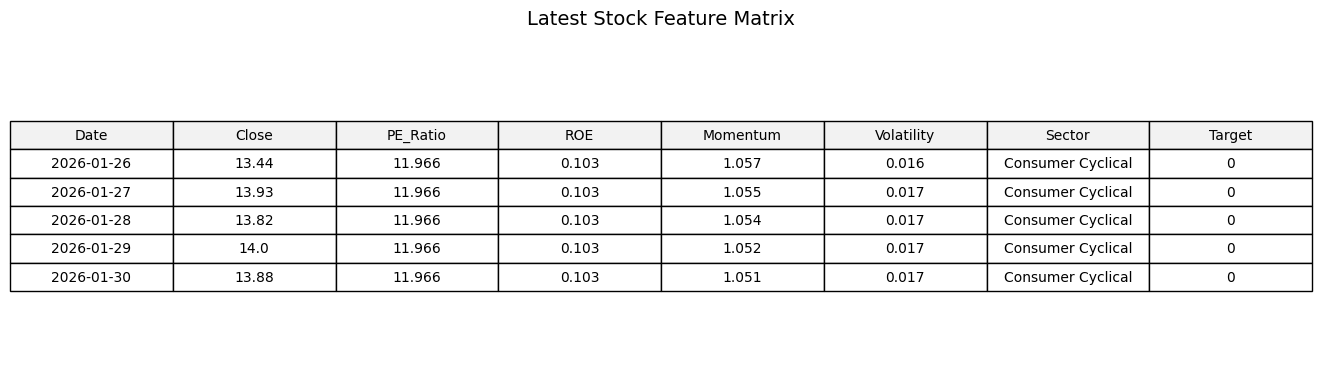

In [30]:
data, intrinsic_price = fetchStockInfo("F")
table_data = data.tail(5).copy()
table_data = table_data.round(3)

# Reset index to make 'Date' a visible column in the table
table_data = table_data.reset_index()
table_data['Date'] = table_data['Date'].dt.strftime('%Y-%m-%d')

# 2. Create the Plot
fig, ax = plt.subplots(figsize=(14, 4)) # Adjust size for your report
ax.axis('tight')
ax.axis('off')

# 3. Create the Table
table = ax.table(cellText=table_data.values, 
                 colLabels=table_data.columns, 
                 cellLoc='center', 
                 loc='center',
                 colColours=["#f2f2f2"] * len(table_data.columns)) # Light grey header

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.7) # Scale for better spacing

plt.title("Latest Stock Feature Matrix", fontsize=14, pad=20)
plt.show()